# Feature Clustering Analysis

Simple workflow for clustering and interpreting learned features:

1. **Load Model** - Extract features from trained rade-features model
2. **Cluster Features** - Apply K-Means or HDBSCAN
3. **Understand with SpLiCE** - Decode clusters to sparse, interpretable concepts
4. **Visualize on Splat** - Plot colored clusters on 3D splat

In [1]:
%load_ext autoreload
%autoreload 2

from pathlib import Path
import numpy as np
import torch
import open3d as o3d
import pyvista as pv
import matplotlib.pyplot as plt
import colorsys

# Import clustering utilities
import clustering_utils as cu

# Collab-splats imports
from collab_splats.wrapper import Splatter, SplatterConfig
from collab_splats.utils.pointcloud import clean_pcd
from collab_splats.utils.visualization import MESH_KWARGS, VIZ_KWARGS, visualize_splat
from nerfstudio.utils.eval_utils import eval_setup

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.
[Taichi] version 1.7.4, llvm 15.0.4, commit b4b956fd, linux, python 3.10.18


[I 11/13/25 00:31:39.937 176049] [shell.py:_shell_pop_print@23] Graphical python shell detected, using wrapped sys.stdout


## Configuration

In [2]:
SPLATS = {
    'birds': {
        'base_dir': '/workspace/fieldwork-data/birds/2024-02-06/',
        'environment': 'environment/C0043/rade-features',
        'load_config': "2025-07-25_040743/config.yml",
        'video_name': 'C0043.mp4',
    },
    'rats': {
        'base_dir': '/workspace/fieldwork-data/rats/2024-07-11/',
        'environment': 'environment/C0119/rade-features',
        'load_config': "2025-07-25_074037/config.yml",
        'video_name': 'C0119.MP4',
    }
}

species = 'rats'
base_dir = Path(SPLATS[species]['base_dir'])
load_config = base_dir / SPLATS[species]['environment'] / SPLATS[species]['load_config']

print(f"Config: {load_config}")
print(f"Exists: {load_config.exists()}")

Config: /workspace/fieldwork-data/rats/2024-07-11/environment/C0119/rade-features/2025-07-25_074037/config.yml
Exists: True


---
## 1. Load Model

In [3]:
# Initialize Splatter
splatter_config = SplatterConfig(
    file_path=base_dir / "SplatsSD" / SPLATS[species]['video_name'],
    method="rade-features",
    frame_proportion=0.25,
)

splatter = Splatter(splatter_config)
splatter.preprocess()
splatter.extract_features()
splatter.mesh()

transforms.json already exists at /workspace/fieldwork-data/rats/2024-07-11/environment/C0119/preproc/transforms.json
To rerun preprocessing, set overwrite=True
Output already exists for rade-features
To rerun feature extraction, set overwrite=True

Available runs:
[0] 2025-07-25_074037


In [4]:
# Load model
config, pipeline, checkpoint_path, step = eval_setup(
    config_path=load_config,
    eval_num_rays_per_chunk=None,
    test_mode='inference'
)

model = pipeline.model
model.eval()

print(f"Model: {type(model).__name__}")
print(f"Gaussians: {model.means.shape[0]:,}")
print(f"Feature dim: {model.config.features_latent_dim}")

Loading cached samclip features...

[00:31:57] use color only optimization with sigmoid activation                                         ]8;id=297905;file:///opt/conda/envs/nerfstudio/lib/python3.10/site-packages/nerfstudio/models/splatfacto.py\splatfacto.py]8;;\:]8;id=186372;file:///opt/conda/envs/nerfstudio/lib/python3.10/site-packages/nerfstudio/models/splatfacto.py#213\213]8;;\

Loading latest checkpoint from load_dir

✅ Done loading checkpoint from 
/workspace/fieldwork-data/rats/2024-07-11/environment/C0119/rade-features/2025-07-25_074037/nerfstudio_models/step-00002
9999.ckpt

Model: RadegsFeaturesModel
Gaussians: 1,295,257
Feature dim: 13


In [6]:
# Extract features
with torch.no_grad():
    features = model.decoder.per_gaussian_forward(model.distill_features)[model.main_features_name].clone().cpu().numpy()
        # model.distill_features.clone().cpu().numpy()
    # features = model.decoder.per_gaussian_forward(features.to(model.device).to(torch.float32))
    positions = model.means.clone().cpu().numpy()
    opacity = model.opacities.clone().cpu().numpy()

print(f"Features: {features.shape}")
print(f"Positions: {positions.shape}")

cu.free_memory()

Features: (1295257, 768)
Positions: (1295257, 3)


---
## 2. Cluster Features

In [ ]:
# Find optimal K using elbow method
k_result = cu.select_optimal_k(
    features,
    k_range=range(2, 50),
    use_minibatch=True,
    verbose=True
)

In [ ]:
# Plot elbow curve
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(k_result['k_values'], k_result['inertias'], marker='o')
ax.axvline(k_result['optimal_k'], color='red', linestyle='--', 
           label=f"Optimal K = {k_result['optimal_k']}")
ax.set_xlabel('K')
ax.set_ylabel('Inertia')
ax.set_title('Elbow Method for Optimal K')
ax.legend()
ax.grid(True)
plt.show()

In [7]:
# Cluster with K-Means
optimal_k = 11 #k_result['optimal_k']  # or set manually: optimal_k = 18

labels, kmeans_model = cu.kmeans_clustering(
    features,
    n_clusters=optimal_k,
    use_minibatch=True,
    verbose=True
)

Performing K-means clustering with K=11 using MiniBatchKMeans...

Cluster distribution:
  Cluster 0: 38,027 samples (2.9%)
  Cluster 1: 228,775 samples (17.7%)
  Cluster 2: 86,552 samples (6.7%)
  Cluster 3: 10,767 samples (0.8%)
  Cluster 4: 131,756 samples (10.2%)
  Cluster 5: 348,132 samples (26.9%)
  Cluster 6: 31,957 samples (2.5%)
  Cluster 7: 35,223 samples (2.7%)
  Cluster 8: 7,887 samples (0.6%)
  Cluster 9: 84,673 samples (6.5%)
  Cluster 10: 291,508 samples (22.5%)


### Alternative: HDBSCAN

**Note:** No MiniBatch version exists

In [ ]:
# # Uncomment to use HDBSCAN
# labels, hdbscan_model = cu.hdbscan_clustering(
#     features,
#     min_cluster_size=100,
#     min_samples=10,
#     verbose=True
# )
# optimal_k = len(set(labels)) - (1 if -1 in labels else 0)

---
## 3. Understand with SpLiCE

SpLiCE decomposes CLIP embeddings into sparse, interpretable concepts.

**Installation:**
```bash
git clone git@github.com:AI4LIFE-GROUP/SpLiCE.git
cd SpLiCE && pip install .
```

In [8]:
# Create SpLiCE model with MaskCLIP using precomputed data (with dtype fix)
import torch
import maskclip_onnx.clip as clip
from splice import SPLICE
# from splice.utils import compute_vocabulary_embeddings

# Configuration
device = "cuda" if torch.cuda.is_available() else "cpu"
data_path = "/workspace/SpLiCE/data"

print("=" * 70)
print("Loading MaskCLIP model and creating SpLiCE")
print("=" * 70)

# Step 1: Load MaskCLIP model
print("\n[1/3] Loading MaskCLIP model...")
clip_model, preprocess = clip.load("ViT-L/14@336px", device=device)
print("✓ MaskCLIP loaded")

Loading MaskCLIP model and creating SpLiCE

[1/3] Loading MaskCLIP model...
✓ MaskCLIP loaded


In [9]:
# Step 2: Load precomputed image mean (ensure float32)
print("\n[2/3] Loading precomputed image mean...")
mean_path = f"{data_path}/means/clip_ViT-L-14-336px_image.pt"
image_mean = torch.load(mean_path, map_location=device).float()  # Convert to float32
print(f"✓ Image mean loaded from: {mean_path}")
print(f"  Shape: {image_mean.shape}, dtype: {image_mean.dtype}")


[2/3] Loading precomputed image mean...
✓ Image mean loaded from: /workspace/SpLiCE/data/means/clip_ViT-L-14-336px_image.pt
  Shape: torch.Size([768]), dtype: torch.float32


In [10]:
# Step 3: Compute/load vocabulary embeddings (dictionary) - now returns float32
print("\n[3/3] Loading vocabulary embeddings...")

dictionary = torch.load(f"{data_path}/embeddings/clip_ViT-L-14-336px_laion_10000_embeddings.pt")
# dictionary = compute_vocabulary_embeddings(
#     clip_model=clip_model,
#     tokenizer=clip.tokenize,
#     vocabulary="laion",
#     model_name="ViT-L-14-336px",
#     library="clip",
#     vocabulary_size=10000,  # Use full vocabulary
#     data_path=data_path,
#     device=device,
#     batch_size=256
# )
# print(f"✓ Dictionary loaded")
print(f"  Shape: {dictionary.shape}, dtype: {dictionary.dtype}")


[3/3] Loading vocabulary embeddings...
  Shape: torch.Size([10000, 768]), dtype: torch.float32


In [11]:
# Create SpLiCE model with MaskCLIP
print("\n" + "=" * 70)
print("Creating SpLiCE model...")
print("=" * 70)

splicemodel = SPLICE(
    image_mean=image_mean,
    dictionary=dictionary,
    clip=clip_model,
    device=device,
    l1_penalty=0.2,
    return_weights=True,
)

print("\n✓ SpLiCE model with MaskCLIP ready!")
print(f"  Dictionary size: {dictionary.shape[0]} concepts")
print(f"  Embedding dim: {dictionary.shape[1]}")
print(f"  All dtypes consistent: float32")
print("=" * 70)


Creating SpLiCE model...

✓ SpLiCE model with MaskCLIP ready!
  Dictionary size: 10000 concepts
  Embedding dim: 768
  All dtypes consistent: float32


In [ ]:
# Decode learned features to CLIP embeddings
print("Decoding learned features to CLIP space...")
with torch.no_grad():
    features_torch = torch.from_numpy(features).to(model.device)
    decoded_dict = model.decoder.per_gaussian_forward(features_torch)
    clip_embeddings = decoded_dict[model.main_features_name]  # (N, D)

print(f"CLIP embeddings shape: {clip_embeddings.shape}")

cu.free_memory()

In [32]:
# Load mesh
mesh_path = splatter.config["mesh_info"]["mesh"]
mesh_features_path = mesh_path.parent / "mesh_features.pt"

print(f"Loading mesh from: {mesh_path}")
print(f"Loading features from: {mesh_features_path}")

# Load mesh features
mesh_features = torch.load(mesh_features_path)
print(f"Mesh features shape: {mesh_features.shape}")

# mesh_features = model.decoder.per_gaussian_forward(mesh_features.to(model.device).to(torch.float32))

# Cluster mesh features
mesh_labels, mesh_kmeans = cu.kmeans_clustering(
    mesh_features,
    n_clusters=11,
    use_minibatch=True,
    verbose=True
)





Loading mesh from: /workspace/fieldwork-data/rats/2024-07-11/environment/C0119/rade-features/mesh/mesh.ply
Loading features from: /workspace/fieldwork-data/rats/2024-07-11/environment/C0119/rade-features/mesh/mesh_features.pt
Mesh features shape: torch.Size([1041518, 13])
Performing K-means clustering with K=11 using MiniBatchKMeans...



Cluster distribution:
  Cluster 0: 519,131 samples (49.8%)
  Cluster 1: 23,704 samples (2.3%)
  Cluster 2: 69,473 samples (6.7%)
  Cluster 3: 44,712 samples (4.3%)
  Cluster 4: 48,048 samples (4.6%)
  Cluster 5: 92,558 samples (8.9%)
  Cluster 6: 18,757 samples (1.8%)
  Cluster 7: 112,748 samples (10.8%)
  Cluster 8: 65,403 samples (6.3%)
  Cluster 9: 26,346 samples (2.5%)
  Cluster 10: 20,638 samples (2.0%)


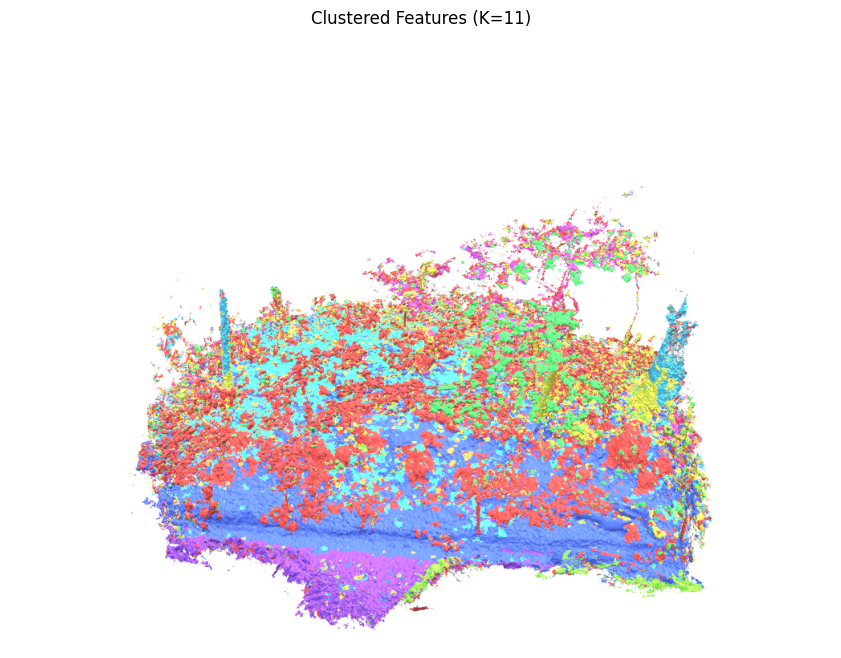

In [42]:
# Plot mesh using pyvista
mesh_o3d = o3d.io.read_triangle_mesh(str(mesh_path))
mesh_vertices = np.asarray(mesh_o3d.vertices)

# Create PyVista mesh
pv_mesh = pv.read(str(mesh_path))

# Visualize clustered splat
pv.start_xvfb()

# Generate distinct colors for clusters
n_clusters = optimal_k
hues = np.linspace(0, 1, n_clusters, endpoint=False)
cluster_colors = np.array([
    [int(c * 255) for c in colorsys.hsv_to_rgb(h, 0.65, 0.95)]
    for h in hues
], dtype=np.uint8)

# cluster_colors = np.stack([c if i == query_label else (0, 0, 0) for i, c in enumerate(cluster_colors)])

point_colors = cluster_colors[mesh_labels]

# query_label = 7
# cluster_filter = mesh_labels == query_label

colors = point_colors #np.array(pv_mesh["RGB"])
# colors[~cluster_filter] = [0, 0, 0]

pv_mesh["RGB"] = colors

# splat = pv.PolyData(points)
# splat.point_data["RGB"] = point_colors

pcd_kwargs = MESH_KWARGS.copy()
pcd_kwargs.update({
    "point_size": 2,
    "render_points_as_spheres": True,
    "ambient": 0.3,
    "diffuse": 0.8,
    "specular": 0.1,
})

plotter = visualize_splat(
    mesh=pv_mesh,
    mesh_kwargs=pcd_kwargs,
    viz_kwargs=VIZ_KWARGS,
)

img = plotter.screenshot()
plt.figure(figsize=(12, 8))
plt.imshow(img)
plt.axis('off')
plt.title(f'Clustered Features (K={optimal_k})')
plt.show()

In [ ]:
mesh_features_path

In [30]:
import splice

query_label = 10
vocabulary = splice.get_vocabulary("laion", 10000)
# avg_embedding = clip_embeddings - clip_embeddings.mean(0).unsqueeze(0)
clip_embeddings = torch.from_numpy(features).to(model.device)
embedding = clip_embeddings[np.where(labels == query_label)[0], :].mean(0).unsqueeze(0)
# embedding = embedding - clip_embeddings.mean(0).unsqueeze(0)

# Normalize embedding
image = torch.nn.functional.normalize(embedding, dim=1)
centered_image = torch.nn.functional.normalize(image-image_mean, dim=1)

weights = splicemodel.decompose(centered_image)

# if self.return_weights and not self.return_cosine:
#     return weights

recon_image = splicemodel.recompose_image(weights)

print (torch.diag(recon_image @ image.T).sum())

# Get top concepts for MaskCLIP
_, indices_maskclip = torch.sort(weights, descending=True)

# Display top 15 concepts
print("\n=== Top 15 Concepts (MaskCLIP) ===")
top_concepts_maskclip = []
for i, idx in enumerate(indices_maskclip.squeeze()[:15]):
    weight = weights[0, idx.item()].item()
    if weight == 0:
        break
    concept = vocabulary[idx.item()]
    top_concepts_maskclip.append((concept, weight))
    print(f"{i+1:2d}. {concept:20s} {weight:.4f}")

tensor(0.6735, device='cuda:0')

=== Top 15 Concepts (MaskCLIP) ===
 1. forest               0.0709
 2. solid                0.0495
 3. hiking               0.0328
 4. truly                0.0275
 5. iso                  0.0210
 6. well                 0.0175
 7. affected             0.0166
 8. barely               0.0148
 9. woods                0.0148
10. finally              0.0137
11. leaves               0.0105
12. canceled             0.0097
13. sound                0.0082
14. words                0.0061
15. announce             0.0057


### Try Different Aggregation Methods

Compare 'mean', 'first', and 'voting' aggregation strategies

In [ ]:
# # Example: Compare aggregation methods for a single cluster
# cluster_id = 0
# cluster_mask = labels == cluster_id
# cluster_clip_embs = clip_embeddings[cluster_mask]
# 
# print(f"Cluster {cluster_id} - Comparing aggregation methods:\n")
# 
# for agg_method in ['mean', 'first', 'voting']:
#     concepts = cu.batch_splice_clip_embeddings(
#         cluster_clip_embs,
#         splicemodel,
#         vocabulary,
#         top_k=5,
#         aggregate=agg_method
#     )
#     print(f"\n{agg_method.upper()}:")
#     for concept, weight in concepts.items():
#         print(f"  {concept}: {weight:.4f}")

---
## 4. Visualize on Splat

In [21]:
# Transform positions to mesh coordinates
mesh_transform = splatter.load_mesh_transform()

points_homo = np.concatenate([positions, np.ones((positions.shape[0], 1))], axis=-1)
points_homo = mesh_transform["mesh_transform"] @ points_homo.T
points = points_homo.T[..., :-1]

In [22]:
# Generate distinct colors for clusters
n_clusters = optimal_k
hues = np.linspace(0, 1, n_clusters, endpoint=False)
cluster_colors = np.array([
    [int(c * 255) for c in colorsys.hsv_to_rgb(h, 0.65, 0.95)]
    for h in hues
], dtype=np.uint8)

# cluster_colors = np.stack([c if i == query_label else (0, 0, 0) for i, c in enumerate(cluster_colors)])

point_colors = cluster_colors[labels]

/opt/conda/envs/nerfstudio/lib/python3.10/site-packages/pyvista/plotting/utilities/xvfb.py:48: PyVistaDeprecationWarning: This function is deprecated and will be removed in future version of PyVista. Use vtk-osmesa instead.
  warnings.warn(


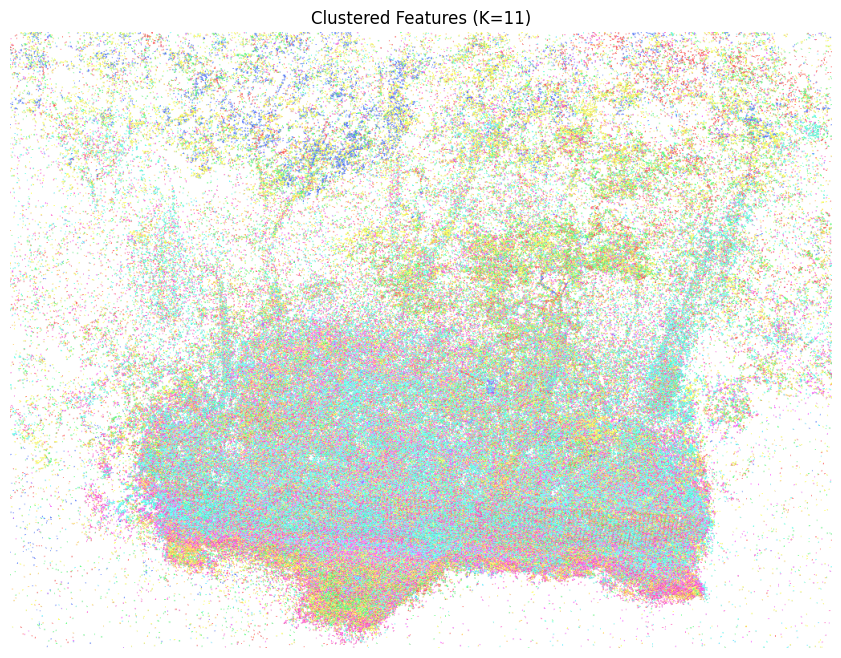

In [23]:
# Visualize clustered splat
pv.start_xvfb()

splat = pv.PolyData(points)
splat.point_data["RGB"] = point_colors

pcd_kwargs = MESH_KWARGS.copy()
pcd_kwargs.update({
    "point_size": 2,
    "render_points_as_spheres": True,
    "ambient": 0.3,
    "diffuse": 0.8,
    "specular": 0.1,
})

plotter = visualize_splat(
    mesh=splat,
    mesh_kwargs=pcd_kwargs,
    viz_kwargs=VIZ_KWARGS,
)

img = plotter.screenshot()
plt.figure(figsize=(12, 8))
plt.imshow(img)
plt.axis('off')
plt.title(f'Clustered Features (K={optimal_k})')
plt.show()

### Visualize Individual Cluster

In [ ]:
# Select cluster
cluster_id = 0

# Get SpLiCE concepts
concepts = cluster_concepts[cluster_id]
top_concept = list(concepts.keys())[0]
top_weight = list(concepts.values())[0]

cluster_mask = labels == cluster_id
cluster_points = points[cluster_mask]

print(f"Cluster {cluster_id}: {top_concept} (weight: {top_weight:.4f})")
print(f"Points: {cluster_points.shape[0]:,}")
print(f"\nTop concepts:")
for concept, weight in concepts.items():
    print(f"  {concept}: {weight:.4f}")

# Visualize
pv_cluster = pv.PolyData(cluster_points)

plotter = pv.Plotter()
plotter.add_points(
    pv_cluster,
    color="red",
    point_size=6,
    render_points_as_spheres=True,
)
plotter.add_text(f"Cluster {cluster_id}: {top_concept}", font_size=12)
plotter.show_grid()

img = plotter.screenshot()
plt.figure(figsize=(12, 8))
plt.imshow(img)
plt.axis('off')
plt.show()

### Visualize Multiple Clusters

In [ ]:
# Select clusters to highlight
clusters_to_highlight = [0, 1, 2]

plotter = pv.Plotter()

# Background
pv_background = pv.PolyData(points)
plotter.add_points(
    pv_background,
    color="lightgray",
    point_size=2,
    opacity=0.3,
)

# Highlight clusters
colors = ["red", "green", "blue", "yellow", "magenta", "cyan"]
for idx, cluster_id in enumerate(clusters_to_highlight):
    cluster_mask = labels == cluster_id
    cluster_points = points[cluster_mask]
    pv_cluster = pv.PolyData(cluster_points)
    
    top_concept = list(cluster_concepts[cluster_id].keys())[0]
    
    plotter.add_points(
        pv_cluster,
        color=colors[idx],
        point_size=6,
        render_points_as_spheres=True,
        label=f"Cluster {cluster_id}: {top_concept}",
    )

plotter.add_legend()
plotter.add_text("Selected Clusters", font_size=12)
plotter.show_grid()

img = plotter.screenshot()
plt.figure(figsize=(12, 8))
plt.imshow(img)
plt.axis('off')
plt.show()

---
## 5. Mesh-Based Clustering

Apply the same K-Means clustering workflow to mesh vertices instead of raw Gaussians.
The mesh features were aggregated from Gaussians during the meshing process (see `features2vertex` in mesh.py:222-293).

In [ ]:
# Load mesh and its features
mesh_path = splatter.config["mesh_info"]["mesh"]
mesh_features_path = mesh_path.parent / "mesh_features.pt"

print(f"Loading mesh from: {mesh_path}")
print(f"Loading features from: {mesh_features_path}")

# Load mesh with Open3D
mesh_o3d = o3d.io.read_triangle_mesh(str(mesh_path))
mesh_vertices = np.asarray(mesh_o3d.vertices)

# Load mesh features (aggregated from Gaussians via features2vertex during meshing)
mesh_features = torch.load(mesh_features_path).numpy()

print(f"\nMesh vertices: {mesh_vertices.shape}")
print(f"Mesh features: {mesh_features.shape}")
print(f"Mesh triangles: {len(mesh_o3d.triangles):,}")

In [ ]:
# Find optimal K for mesh features (may differ from Gaussian clustering)
print("Finding optimal K for mesh features...")
mesh_k_result = cu.select_optimal_k(
    mesh_features,
    k_range=range(2, 50),
    use_minibatch=True,
    verbose=True
)

# Plot elbow curve
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(mesh_k_result['k_values'], mesh_k_result['inertias'], marker='o')
ax.axvline(mesh_k_result['optimal_k'], color='red', linestyle='--', 
           label=f"Optimal K = {mesh_k_result['optimal_k']}")
ax.set_xlabel('K')
ax.set_ylabel('Inertia')
ax.set_title('Elbow Method for Optimal K (Mesh Features)')
ax.legend()
ax.grid(True)
plt.show()

In [ ]:
# Cluster mesh vertices with K-Means
mesh_optimal_k = mesh_k_result['optimal_k']  # or set manually: mesh_optimal_k = 15

print(f"\nClustering mesh with K={mesh_optimal_k}...")
mesh_labels, mesh_kmeans = cu.kmeans_clustering(
    mesh_features,
    n_clusters=mesh_optimal_k,
    use_minibatch=True,
    verbose=True
)

print(f"\nClustered {len(mesh_vertices):,} mesh vertices into {mesh_optimal_k} clusters")
print(f"\nCluster distribution:")
for cluster_id in range(mesh_optimal_k):
    count = np.sum(mesh_labels == cluster_id)
    print(f"  Cluster {cluster_id}: {count:,} vertices ({count/len(mesh_labels)*100:.1f}%)")

In [ ]:
# Decode mesh features to CLIP embeddings
print("Decoding mesh features to CLIP space...")
with torch.no_grad():
    mesh_features_torch = torch.from_numpy(mesh_features).to(model.device)
    mesh_decoded_dict = model.decoder.per_gaussian_forward(mesh_features_torch)
    mesh_clip_embeddings = mesh_decoded_dict[model.main_features_name]

print(f"Mesh CLIP embeddings shape: {mesh_clip_embeddings.shape}")

# Decode all mesh clusters with SpLiCE
print("\nDecoding mesh clusters with SpLiCE...")
mesh_cluster_concepts = {}

for cluster_id in range(mesh_optimal_k):
    cluster_mask = mesh_labels == cluster_id
    cluster_clip_embs = mesh_clip_embeddings[cluster_mask]
    
    concepts = cu.batch_splice_clip_embeddings(
        cluster_clip_embs,
        splicemodel,
        vocabulary,
        top_k=10,
        aggregate='mean'
    )
    
    mesh_cluster_concepts[int(cluster_id)] = concepts

# Print results
print("\nMesh Cluster Concepts (SpLiCE):")
for cluster_id, concepts in mesh_cluster_concepts.items():
    cluster_mask = mesh_labels == cluster_id
    print(f"\nCluster {cluster_id} ({cluster_mask.sum():,} vertices):")
    for i, (concept, weight) in enumerate(list(concepts.items())[:5], 1):
        print(f"  {i}. {concept}: {weight:.4f}")

cu.free_memory()

### Visualize Clustered Mesh

In [ ]:
# Generate distinct colors for mesh clusters
mesh_hues = np.linspace(0, 1, mesh_optimal_k, endpoint=False)
mesh_cluster_colors = np.array([
    [c for c in colorsys.hsv_to_rgb(h, 0.65, 0.95)]
    for h in mesh_hues
], dtype=np.float32)

# Assign colors to vertices
mesh_vertex_colors = mesh_cluster_colors[mesh_labels]

# Create PyVista mesh
pv_mesh = pv.read(str(mesh_path))
pv_mesh.point_data["cluster_colors"] = mesh_vertex_colors

# Visualize
clustered_mesh_kwargs = {
    "scalars": "cluster_colors",
    "rgb": True,
    "smooth_shading": True,
}

plotter = visualize_splat(
    mesh=pv_mesh,
    mesh_kwargs=clustered_mesh_kwargs,
    viz_kwargs=VIZ_KWARGS,
)

img = plotter.screenshot()
plt.figure(figsize=(14, 10))
plt.imshow(img)
plt.axis('off')
plt.title(f'Clustered Mesh (K={mesh_optimal_k})', fontsize=16)
plt.show()

### Visualize Individual Mesh Cluster

In [ ]:
# Select a mesh cluster to visualize
mesh_cluster_id = 0

# Get SpLiCE concepts
mesh_concepts = mesh_cluster_concepts[mesh_cluster_id]
mesh_top_concept = list(mesh_concepts.keys())[0]
mesh_top_weight = list(mesh_concepts.values())[0]

mesh_cluster_mask = mesh_labels == mesh_cluster_id
n_vertices_in_cluster = np.sum(mesh_cluster_mask)

print(f"Mesh Cluster {mesh_cluster_id}: {mesh_top_concept} (weight: {mesh_top_weight:.4f})")
print(f"Vertices: {n_vertices_in_cluster:,} ({n_vertices_in_cluster/len(mesh_labels)*100:.1f}%)")
print(f"\nTop concepts:")
for concept, weight in mesh_concepts.items():
    print(f"  {concept}: {weight:.4f}")

# Create highlighted mesh
pv_mesh_highlight = pv_mesh.copy()
highlight_colors = np.ones((len(mesh_vertices), 3)) * 0.8  # Light gray
highlight_colors[mesh_cluster_mask] = [1.0, 0.0, 0.0]  # Red for selected

pv_mesh_highlight.point_data["highlight_colors"] = highlight_colors

highlight_kwargs = {
    "scalars": "highlight_colors",
    "rgb": True,
    "smooth_shading": True,
}

plotter = visualize_splat(
    mesh=pv_mesh_highlight,
    mesh_kwargs=highlight_kwargs,
    viz_kwargs=VIZ_KWARGS,
)

img = plotter.screenshot()
plt.figure(figsize=(14, 10))
plt.imshow(img)
plt.axis('off')
plt.title(f'Mesh Cluster {mesh_cluster_id}: {mesh_top_concept}', fontsize=16)
plt.show()

### Compare Multiple Mesh Clusters

In [ ]:
# Select multiple mesh clusters to compare
mesh_clusters_to_compare = [0, 1, 2]

# Create side-by-side comparison
fig, axes = plt.subplots(1, len(mesh_clusters_to_compare), figsize=(18, 6))

for idx, cluster_id in enumerate(mesh_clusters_to_compare):
    concepts = mesh_cluster_concepts[cluster_id]
    top_concept = list(concepts.keys())[0]
    cluster_mask = mesh_labels == cluster_id
    
    # Create highlighted mesh
    pv_mesh_compare = pv_mesh.copy()
    compare_colors = np.ones((len(mesh_vertices), 3)) * 0.9  # Light gray
    compare_colors[cluster_mask] = mesh_cluster_colors[cluster_id]
    pv_mesh_compare.point_data["compare_colors"] = compare_colors
    
    compare_kwargs = {
        "scalars": "compare_colors",
        "rgb": True,
        "smooth_shading": True,
    }
    
    plotter = visualize_splat(
        mesh=pv_mesh_compare,
        mesh_kwargs=compare_kwargs,
        viz_kwargs=VIZ_KWARGS,
    )
    
    img = plotter.screenshot()
    axes[idx].imshow(img)
    axes[idx].axis('off')
    axes[idx].set_title(f'Cluster {cluster_id}: {top_concept}', fontsize=12)
    plotter.close()

plt.tight_layout()
plt.show()

# Print concept comparison
print("\nConcept Comparison:")
for cluster_id in mesh_clusters_to_compare:
    concepts = mesh_cluster_concepts[cluster_id]
    cluster_mask = mesh_labels == cluster_id
    print(f"\nCluster {cluster_id} ({np.sum(cluster_mask):,} vertices):")
    for i, (concept, weight) in enumerate(list(concepts.items())[:5], 1):
        print(f"  {i}. {concept}: {weight:.4f}")

### Save Clustered Mesh

---
## Summary

This workflow demonstrates:

1. **Load Model** - Extract features from rade-features model
2. **Cluster Gaussians** - K-Means clustering on raw Gaussian features
3. **Understand with SpLiCE** - Sparse, interpretable concept decomposition
4. **Visualize Gaussians** - PyVista visualization of Gaussian clusters
5. **Cluster Mesh** - Same K-Means workflow on mesh vertex features

### Key Points:

**Gaussian vs Mesh Clustering:**
- **Gaussian clustering**: Clusters raw 3D Gaussians (100k-1M points, noisy)
- **Mesh clustering**: Clusters mesh vertices (10k-100k points, cleaner surface)
- Both use identical K-Means + SpLiCE workflow
- Mesh features are aggregated from Gaussians via `features2vertex()` during meshing

**Workflow (Same for Both):**
1. Load features (Gaussian features OR mesh features from `mesh_features.pt`)
2. Find optimal K using elbow method
3. K-Means clustering on features
4. Decode to CLIP embeddings
5. SpLiCE interpretation
6. Visualize and save

**Why Cluster the Mesh:**
- Cleaner surface representation
- Faster (fewer vertices)
- Better for surface-based semantic analysis
- Smoother visualization with mesh shading
- Easier to export and share results

**Modular SpLiCE Functions:**
- `splice_clip_embeddings()` - Decode single CLIP embedding
- `batch_splice_clip_embeddings()` - Decode batch of embeddings with aggregation ('mean', 'first', 'voting')
- Model loading and feature extraction handled separately in notebook

**MiniBatch HDBSCAN:**
- Does NOT exist - use MiniBatchKMeans for large datasets

**SpLiCE:**
- Decomposes dense CLIP embeddings into sparse concepts
- More interpretable than raw CLIP text matching
- Install: `git clone git@github.com:AI4LIFE-GROUP/SpLiCE.git && cd SpLiCE && pip install .`

**Performance:**
- Use `use_minibatch=True` for >100k samples
- Automatic K selection via elbow method
- Mesh clustering typically 5-10x faster than Gaussian clustering

**Output Files:**
- **Gaussians**: Visualizations only (not saved)
- **Mesh**: `mesh_clustered_kN.ply` - Clustered mesh with colors
- **Mesh**: `mesh_cluster_data_kN.pkl` - Labels, concepts, and metadata